In [1]:
#confidence_levels.ipynb 
# 
#by Joe Hahn
#joe.hahn@oracle.com
#18 July 2018
#
#plot the MLP model's confidence levels

In [2]:
#set system parameters
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 1.0
rn_seed = 15
initial_id = 0

In [3]:
#generate sample of xo data
N_dots = 20000
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
xo = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
xo.tail()

,id,x,y,r,angle,class,X_score,O_score,B_score
record,,,,,,,,,
19995,19995,2.771012,4.464528,5.254571,1.015315,B,0.0,0.0,1.0
19996,19996,-2.330889,2.722251,3.583810,2.278900,X,1.0,0.0,0.0
19997,19997,4.467448,-2.383753,5.063633,-0.490151,B,0.0,0.0,1.0
19998,19998,5.008518,0.172893,5.011501,0.034506,B,0.0,0.0,1.0
19999,19999,0.767303,0.526716,0.930690,0.601575,O,0.0,1.0,0.0


In [4]:
#extract x-features and y = target variables
x_cols = ['x', 'y']
y_cols = ['O_score', 'X_score', 'B_score']
N_classes = len(y_cols)
print 'N_classes = ', N_classes
x = xo[x_cols].values
y = xo[y_cols].values
print x.shape, y.shape

N_classes =  3
(20000, 2) (20000, 3)


In [5]:
#load mlp model
from keras.models import load_model
model = load_model('mlp_model.h5')

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
#generate predictions and stash results in xo dataframe
y_pred = model.predict(x)
import pandas as pd
cols = [col + '_pred' for col in y_cols]
y_pred_df = pd.DataFrame(data=y_pred, columns=cols)
#normalize class scores
xo['sum'] = 0.0
for col in y_pred_df.columns:
    xo[col] = y_pred_df[col]
    xo['sum'] += y_pred_df[col]
for col in y_pred_df.columns:
    xo[col] /= xo['sum']
xo['sum'] = 0.0
for col in y_pred_df.columns:
    xo['sum'] += xo[col]
cols = y_pred_df.columns
xo['class_score'] = xo.apply(lambda x: x[cols].max(), axis=1)
xo['class_pred'] = xo.apply(lambda x: cols[x[cols].values.argmax()][0], axis=1)
cols = ['id', 'x', 'y', 'class', 'class_score', 'class_pred']
xo[cols].head(10)

,id,x,y,class,class_score,class_pred
record,,,,,,
0,0,2.804608,-2.908867,B,0.592253,X
1,1,-6.110658,-1.691350,B,0.873703,B
2,2,6.813217,1.766947,B,0.932734,B
3,3,6.249304,-2.576105,B,0.831837,B
4,4,-7.114995,-0.576832,B,0.983245,B
5,5,-6.755185,1.296075,B,0.935550,B
6,6,0.445851,6.814989,B,1.001089,B
7,7,0.702584,8.979770,B,1.032642,B
8,8,-4.029477,4.446405,X,0.721208,X


In [7]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

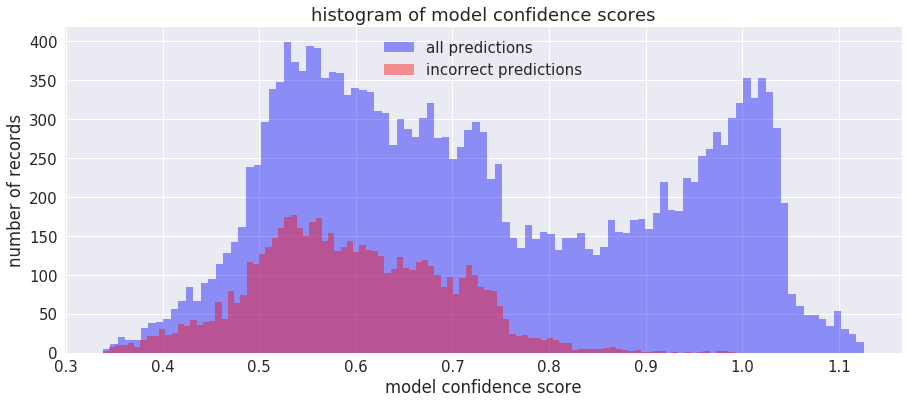

In [8]:
#histogram model confidence
N_bins = 101
fig, ax = plt.subplots(1,1, figsize=(15, 6))
#historgram all predictions
xp = xo.class_score
p = sns.distplot(xp, bins=N_bins, ax=ax, kde=False, color='blue', label='all predictions')
#histogram incorrect predictions
idx = (xo['class'] != xo['class_pred'])
xp = xo[idx].class_score
p = sns.distplot(xp, bins=N_bins, ax=ax, kde=False, color='red', label='incorrect predictions')
p = ax.set_title('histogram of model confidence scores')
p = ax.set_xlabel('model confidence score')
p = ax.set_ylabel('number of records')
p = ax.legend()
ax.figure.savefig('figs/mlp_confidence_scores.png')